# Resources Calculator


In [1]:



%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


In [15]:
import os
import pandas as pd
import ipywidgets as widgets
from ipyleaflet import Map, basemaps, Marker
from pandas import DataFrame
from numpy import loadtxt
import sys
import numpy as np
import netCDF4 as nc
import calendar
import matplotlib.pyplot as plt
import watermark

### PLEASE SPECIFY YOUR LOCATION
Provide coordinates:

In [16]:

   
LAT =  widgets.FloatText(
    value= 50,
    description='LAT:',
    disabled=False)

LON = widgets.FloatText(
    value=20,
    description='LAT:',
    disabled=False)

display (LAT, LON)



FloatText(value=50.0, description='LAT:')

FloatText(value=20.0, description='LAT:')

...or drag a pointer on the map below

In [17]:
m = Map(
    basemap=basemaps.OpenStreetMap.Mapnik,
    center=(LAT.value, LON.value),zoom=4)
centerm=(LAT.value, LON.value)
marker = Marker(location=centerm, draggable=True)

m.add_layer(marker);



m

Map(center=[50.0, 20.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…

In [21]:
#overwrite coordinates

latitude = LAT.value
longitude = LON.value
latitude = marker.location[0]
longitude = marker.location[1]
print("LATITUDE: ",latitude)
print("LONGITUDE : ",longitude)
    
    




LATITUDE:  50.0
LONGITUDE :  20.0


### PLEASE SELECT YOUR HABITAT(S)
use 'ctrl' or 'shift' for multiple selection

In [20]:

h= widgets.SelectMultiple(
    options=['Meadow', 'Forest', 'Bog', "Coastal","Grassland","Other" ],
    value=['Meadow'],
    #rows=10,
    description='HABITATS',
    disabled=False
)
h


SelectMultiple(description='HABITATS', index=(0,), options=('Meadow', 'Forest', 'Bog', 'Coastal', 'Grassland',…

In [22]:

hablist=h.value

print("habitats chosen : ",hablist)

percframe = pd.DataFrame(columns=["HABITAT", "%"])
left = 100    
for i in hablist:
    print ('{}% available'.format(left))
    val = int(input("Enter percentage of {}: ".format(i)))
    left =left - val
    df2 = [i,val]
    df_length = len(percframe)
    percframe.loc[df_length] = df2
    percframe.append (df2, ignore_index = True)

printable = percframe.to_string(index=False)
if left == 0:
    print()
    print ("Your environment:")
    print (printable)
else:
    print()
    print("!!!")
    print()
    print ("ERROR - percentages does not summ up to 100%"  )
    print ("please re-run the cell")

habitats chosen :  ('Grassland',)
100% available
Enter percentage of Grassland: 100

Your environment:
   HABITAT    %
 Grassland  100


### ENVIRONMENT DATA STACKING

In [23]:
base_dir = "C:/Flowering/"
plant_data = os.path.join(base_dir, "results/" )
output = os.path.join(base_dir, "results/habitat.csv")


count=0
phen = pd.read_csv(plant_data + "phenology.csv", sep=";")
phen = phen = phen.set_index('PLANT_NO')
prod = pd.read_csv(plant_data + "production.csv", sep=";")
prod = prod.set_index('PLANT_NO')
stack = pd.DataFrame(columns=["PLANT", "SGDD", "PGDD", "EGDD", "PMAX", "NMAX", "SMAX"])

for index, row  in percframe.iterrows():
    Hab = pd.read_csv(plant_data + row['HABITAT'] +".csv", sep=";")
    per= int(row['%'])
    for index, row in Hab.iterrows():
        
        prodrow = prod.loc[row["PLANT_NO"]]
        plantdensperc = row['flower_density_mean']*per/100
        
        if (prodrow['pollen_flower_day_mean'] == -1):
               print("Not possible to calculate")
        else:
            if (prodrow['pollen_flower_day_mean']== -2): 
                plantp = 2 * prodrow ["pollen_yield_mean"] × 100 /prodrow["flower_length"]
            else:
                plantp = plantdensperc * prodrow["pollen_flower_day_mean"]/1000

        if (prodrow['nectar_flower_day_mean'] == -1):
               print("Not possible to calculate")
        else:
            if (prodrow['nectar_flower_day_mean']== -2): 
                plantn = 2 * prodrow ["nectar_yield_mean"] × 100 /prodrow["flower_length"]
            else:
                plantn = plantdensperc * prodrow["nectar_flower_day_mean"]/1000

        if (prodrow['sugar_flower_day_mean'] == -1):
               print("Not possible to calculate")
        else:
            if (prodrow['sugar_flower_day_mean']== -2): 
                plants = 2 * prodrow ["sugar_yield_mean"] × 100 /prodrow["flower_length"]
            else:
                plants = plantdensperc * prodrow["sugar_flower_day_mean"]/1000
         
        
        phenrow = phen.loc[row["PLANT_NO"]]
        plantstart = phenrow['SGDD']
        plantpeak = phenrow['PGDD']
        plantend = phenrow['EGDD']
        
        stack.at[count, "PMAX"] = plantp
        stack.at[count, "NMAX"] = plantn
        stack.at[count, "SMAX"] = plants
        
        stack.at[count, "SGDD"] = plantstart
        stack.at[count, "PGDD"] = plantpeak
        stack.at[count, "EGDD"] = plantend
        
        stack.at[count, "PLANT"] = row['PLANT_NO']
        count = count + 1 

print (stack)


  PLANT SGDD PGDD EGDD     PMAX        NMAX        SMAX
0   292  100  300  500  184.211     1459.97     933.739
1   666  100  300  500  36.3145     401.702     188.427
2    77  100  300  500  1.00975  0.00361472  0.00191488
3    94  100    0  500  765.692     83.3463     43.7642
4   634  100  300  500  249.922     94539.6     35225.5
5   693  100  300  500   169.91     410.198     114.881
6   110  100  300  500  79.6644      2970.1     1607.79
7   689  100  300  500  147.773     9.62521     3.84768
8    99  100  300  500  604.805     27524.6     15270.4


### CALCULATING POLEN MODEL CURVES

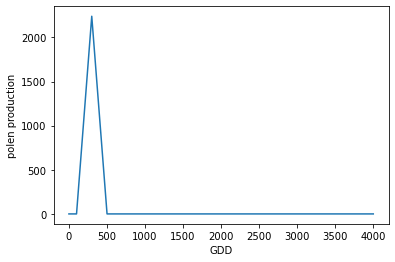

In [24]:
columns =list(range(4000))
ComboHabitat = pd.DataFrame(columns=columns)
for index, row in stack.iterrows():

    Fstart= round(row['SGDD'])
    Fend = round(row['EGDD'])
    Fpeak = round(row['PGDD'])
    Pmaxprod = (row['PMAX'])

     
    
    if (Fend > 0) & (Fend > Fstart):
        Flen = Fend - Fstart
        
    elif (Fend == 0)&(Fpeak > 0) & (Fpeak > Fstart):
        Flen = 2*(Fpeak - Fstart)
    
    else: Flen = 100

    if (Fpeak > 0) & (Fpeak > Fstart):
        print ()

    else: Fpeak = Fstart + (Flen / 2)
    F1 = Fpeak - Fstart

    if (Fpeak > 0) & (Fend > 0) & (Fend> Fpeak):
        print ()
    else: Fend = Fstart + Flen
    F2 = Fend - Fpeak

    plant = []
    for i in range (0,Fstart):
        plant.append(0)

    for y in range (0, Flen):

        if y < F1:
            plant.append (Pmaxprod/F1 * y)
        elif y == F1:
            plant.append (Pmaxprod)
        else:
            plant.append (Pmaxprod/F2 * (Flen-y) )

    rest = 4000-Fstart-Flen

    #print (F1)
    #print (F2)
    #print (rest)
    #print (Fstart)
    #print (Flen)

    for n in range (0,rest):
        plant.append(0)
    #print (plant)
    #print(len(plant))
   # Dataframe.append(plant, ignore_index=True)
  #  Dataframe.append(pd.Series(plant, index=Dataframe.columns[:len(plant)]), ignore_index=True)
    df_length = len(ComboHabitat)

    ComboHabitat.loc[df_length] = plant

#print (ComboHabitat)
Habi_out=ComboHabitat.sum(axis = 0, skipna = True)
Habi_outP = DataFrame (Habi_out,columns=['VAL'])
#print(Habi_outP)


plt.plot(Habi_outP)
plt.ylabel('polen production')
plt.xlabel('GDD')
plt.show()


### CALCULATING NECTAR MODEL CURVES

In [ ]:
columns =list(range(4000))
ComboHabitat = pd.DataFrame(columns=columns)
for index, row in stack.iterrows():

    Fstart= round(row['SGDD'])
    Fend = round(row['EGDD'])
    Fpeak = round(row['PGDD'])
    Nmaxprod = (row['NMAX'])

    if (Fend > 0) & (Fend > Fstart):
        Flen = Fend - Fstart
    else: Flen = 100

    if (Fpeak > 0) & (Fpeak > Fstart):
        print ()

    else: Fpeak = Fstart + (Flen / 2)
    F1 = Fpeak - Fstart

    if (Fpeak > 0) & (Fend > 0) & (Fend> Fpeak):
        print ()
    else: Fend = Fstart + Flen
    F2 = Fend - Fpeak

    plant = []
    for i in range (0,Fstart):
        plant.append(0)

    for y in range (0, Flen):

        if y < F1:
            plant.append (Nmaxprod/F1 * y)
        elif y == F1:
            plant.append (Nmaxprod)
        else:
            plant.append (Nmaxprod/F2 * (Flen-y) )

    rest = 4000-Fstart-Flen

    #print (F1)
    #print (F2)
    #print (rest)
    #print (Fstart)
    #print (Flen)

    for n in range (0,rest):
        plant.append(0)
    #print (plant)
    #print(len(plant))
   # Dataframe.append(plant, ignore_index=True)
  #  Dataframe.append(pd.Series(plant, index=Dataframe.columns[:len(plant)]), ignore_index=True)
    df_length = len(ComboHabitat)

    ComboHabitat.loc[df_length] = plant

#print (ComboHabitat)
Habi_out=ComboHabitat.sum(axis = 0, skipna = True)
Habi_outN = DataFrame (Habi_out,columns=['VAL'])
#print(Habi_outN)
plt.plot(Habi_outN)
plt.ylabel('nectar production')
plt.xlabel('GDD')
plt.show()



### CALCULATING SUGAR MODEL CURVES

In [ ]:
columns =list(range(4000))
ComboHabitat = pd.DataFrame(columns=columns)
for index, row in stack.iterrows():

    Fstart= round(row['SGDD'])
    Fend = round(row['EGDD'])
    Fpeak = round(row['PGDD'])
    Smaxprod = (row['SMAX'])

    if (Fend > 0) & (Fend > Fstart):
        Flen = Fend - Fstart
    else: Flen = 100

    if (Fpeak > 0) & (Fpeak > Fstart):
        print ()

    else: Fpeak = Fstart + (Flen / 2)
    F1 = Fpeak - Fstart

    if (Fpeak > 0) & (Fend > 0) & (Fend> Fpeak):
        print ()
    else: Fend = Fstart + Flen
    F2 = Fend - Fpeak

    plant = []
    for i in range (0,Fstart):
        plant.append(0)

    for y in range (0, Flen):

        if y < F1:
            plant.append (Smaxprod/F1 * y)
        elif y == F1:
            plant.append (Smaxprod)
        else:
            plant.append (Smaxprod/F2 * (Flen-y) )

    rest = 4000-Fstart-Flen

    #print (F1)
    #print (F2)
    #print (rest)
    #print (Fstart)
    #print (Flen)

    for n in range (0,rest):
        plant.append(0)
    #print (plant)
    #print(len(plant))
   # Dataframe.append(plant, ignore_index=True)
  #  Dataframe.append(pd.Series(plant, index=Dataframe.columns[:len(plant)]), ignore_index=True)
    df_length = len(ComboHabitat)

    ComboHabitat.loc[df_length] = plant

#print (ComboHabitat)
Habi_out=ComboHabitat.sum(axis = 0, skipna = True)
Habi_outS = DataFrame (Habi_out,columns=['VAL'])
#print(Habi_outS)


plt.plot(Habi_outS)
plt.ylabel('sugar production')
plt.xlabel('GDD')
plt.show()

### PLEASE CHOOSE YEAR(S) FOR SIMULATION

In [ ]:

year= widgets.IntRangeSlider(
    value=[1980, 1990],
    min=1950,
    max=2000,
    step=1,
    description='Years:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)
display(year)
resyear = year.value

In [ ]:
YRS = [*range(year.value[0], year.value[1])]
print("Processing weather data for years ",YRS)
URlat = latitude
URlon = longitude
base_dir = "C:/Flowering/"
habi_data = os.path.join(base_dir,"results/" )
E_OBS_data = os.path.join(base_dir, "input_data/E_OBS_data/")

# Output file
output = os.path.join(base_dir, f"results/{year}.csv")

# ### E-OBS data importing and pre-processing
# Importing elevation data
elev = nc.Dataset(E_OBS_data + "elev_ens_0.1deg_reg_v22.0e.nc")

# Extracting lon, lat data
lats = elev.variables['latitude'][:]
lons = elev.variables['longitude'][:]

# E_OBS data regions
reg1 = list(range(1950, 1965))
reg2 = list(range(1965, 1980))
reg3 = list(range(1980, 1995))
reg4 = list(range(1995, 2011))
reg5 = list(range(2011, 2021))


# this function returs region no and start year
def eobs_data_reg(year):
    if (year in reg1):
        return [1950, 1964]
    elif (year in reg2):
        return [1965, 1979]
    elif (year in reg3):
        return [1980, 1994]
    elif (year in reg4):
        return [1995, 2010]
    else:
        return [2011, 2020]


# Find the nearest latitude and longitude for a given location (indexes)
def getclosest_idx(latpt, lonpt):
    lat_idx = np.abs(lats - latpt).argmin()
    lon_idx = np.abs(lons - lonpt).argmin()
    return [lat_idx, lon_idx]



 

### RUNNING SIMULATION...

In [ ]:
columns =list(range(1, 366))
years_mean = pd.DataFrame(columns=columns)
for year in YRS:
    #print("calculating polen production for ", year)
    # Importing species phenological data
    #print(year)
    #print(habitat.columns)
    habi = Habi_outP["VAL"].tolist()

    lat_idx = getclosest_idx(URlat, URlon)[0]
    lon_idx = getclosest_idx(URlat, URlon)[1]

    # accesing the proper E-OBS files
    start = str(eobs_data_reg(year)[0])
    #print(start)
    end = str(eobs_data_reg(year)[1])
    #print(end)
    min_temp = nc.Dataset(E_OBS_data + "tn_ens_mean_" + start + "-" + end + ".nc").variables['tn']
    max_temp = nc.Dataset(E_OBS_data + "tx_ens_mean_" + start + "-" + end + ".nc").variables['tx']


    #calculating mean temperature for every day in a  chosen year
   
    total_days = 0
    #print(start)
    #print(year)
    years = list(range(int(start), int(year)))
    #print(years)
    if len(years) > 0:
         for yr in years:
            if calendar.isleap(yr):
                total_days = total_days + 366  
                
            else:
                total_days = total_days + 365

          
    
    slice_min_temp = min_temp[int(total_days):int(total_days)+365, lat_idx, lon_idx]
    slice_max_temp = max_temp[int(total_days):int(total_days)+365, lat_idx, lon_idx]
    #print(slice_min_temp)
    #print(len(slice_min_temp))
    
    columns =list(range(1, 366))
    #print(len(columns))
    #print(columns)
    templist = pd.DataFrame(columns=columns)
    df_length = len(templist)
    templist.loc[df_length] = slice_min_temp
    df_length = len(templist)
    templist.loc[df_length] = slice_max_temp
    templist_out=templist.sum(axis = 0, skipna = True)
    templist_mean = templist_out/2
    #print(templist_mean)


    #calculating daily production based on habitat GDD production

    count = 0
    ping = 0
    pong = 0
    prodP = []
    for tmp in templist_mean:
        if tmp > 4:
            pong = pong + round(tmp)
            #print(ping)
            #print(pong)
            dayprod = max([habi[i] for i in range(ping, pong)])
            prodP.append(dayprod)
            ping = pong
            count = count + 1
        else:
            #print("too cold")
            prodP.append(0.0)

    #print (prodP)
    print ( "year", year,",", count, "days above 4 deg C", ", total production of polen was", sum(prodP),"kg/ha")
    df_length = len(years_mean)
    years_mean.loc[df_length] = prodP
    
    #plt.plot(prodP)
    #plt.ylabel('polen production in [kg/ha]')
    #plt.xlabel('days')
    #plt.show()

finalP=years_mean.sum(axis = 0, skipna = True)/len(YRS)




In [ ]:
columns =list(range(1, 366))
years_mean = pd.DataFrame(columns=columns)
for year in YRS:
    #print("calculating  nectar production for ", year)
    # Importing species phenological data
    #print(year)
    #print(habitat.columns)
    habi = Habi_outN["VAL"].tolist()
    

    lat_idx = getclosest_idx(URlat, URlon)[0]
    lon_idx = getclosest_idx(URlat, URlon)[1]

    # accesing the proper E-OBS files
    start = str(eobs_data_reg(year)[0])
    #print(start)
    end = str(eobs_data_reg(year)[1])
    #print(end)
    min_temp = nc.Dataset(E_OBS_data + "tn_ens_mean_" + start + "-" + end + ".nc").variables['tn']
    max_temp = nc.Dataset(E_OBS_data + "tx_ens_mean_" + start + "-" + end + ".nc").variables['tx']


    #calculating mean temperature for every day in a  chosen year
   
    total_days = 0
    #print(start)
    #print(year)
    years = list(range(int(start), int(year)))
    #print(years)
    if len(years) > 0:
         for yr in years:
            if calendar.isleap(yr):
                total_days = total_days + 366  
                
            else:
                total_days = total_days + 365

          
    
    slice_min_temp = min_temp[int(total_days):int(total_days)+365, lat_idx, lon_idx]
    slice_max_temp = max_temp[int(total_days):int(total_days)+365, lat_idx, lon_idx]
    #print(slice_min_temp)
    #print(len(slice_min_temp))
    
    columns =list(range(1, 366))
    #print(len(columns))
    #print(columns)
    templist = pd.DataFrame(columns=columns)
    df_length = len(templist)
    templist.loc[df_length] = slice_min_temp
    df_length = len(templist)
    templist.loc[df_length] = slice_max_temp
    templist_out=templist.sum(axis = 0, skipna = True)
    templist_mean = templist_out/2
    #print(templist_mean)


    #calculating daily production based on habitat GDD production

    count = 0
    ping = 0
    pong = 0
    prodN = []
    for tmp in templist_mean:
        if tmp > 4:
            pong = pong + round(tmp)
            #print(ping)
            #print(pong)
            dayprod = max([habi[i] for i in range(ping, pong)])
            prodN.append(dayprod)
            ping = pong
            count = count + 1
        else:
            #print("too cold")
            prodN.append(0.0)

    #print (prodN)
    print ( "year", year,",", count, "days above 4 deg C", ", total nectar production was", sum(prodN),"kg/ha")
    df_length = len(years_mean)
    years_mean.loc[df_length] = prodN
    
    #plt.plot(prodN)
    #plt.ylabel('nectar production in [kg/ha]')
    #plt.xlabel('days')
    #plt.show()

finalN=years_mean.sum(axis = 0, skipna = True)/len(YRS)

In [ ]:
columns =list(range(1, 366))
years_mean = pd.DataFrame(columns=columns)
for year in YRS:
    #print("calculating  sugar production for ", year)
    # Importing species phenological data
    #print(year)
    #print(habitat.columns)
    habi = Habi_outS["VAL"].tolist()
    

    lat_idx = getclosest_idx(URlat, URlon)[0]
    lon_idx = getclosest_idx(URlat, URlon)[1]

    # accesing the proper E-OBS files
    start = str(eobs_data_reg(year)[0])
    #print(start)
    end = str(eobs_data_reg(year)[1])
    #print(end)
    min_temp = nc.Dataset(E_OBS_data + "tn_ens_mean_" + start + "-" + end + ".nc").variables['tn']
    max_temp = nc.Dataset(E_OBS_data + "tx_ens_mean_" + start + "-" + end + ".nc").variables['tx']


    #calculating mean temperature for every day in a  chosen year
   
    total_days = 0
    #print(start)
    #print(year)
    years = list(range(int(start), int(year)))
    #print(years)
    if len(years) > 0:
         for yr in years:
            if calendar.isleap(yr):
                total_days = total_days + 366  
                
            else:
                total_days = total_days + 365

          
    
    slice_min_temp = min_temp[int(total_days):int(total_days)+365, lat_idx, lon_idx]
    slice_max_temp = max_temp[int(total_days):int(total_days)+365, lat_idx, lon_idx]
    #print(slice_min_temp)
    #print(len(slice_min_temp))
    
    columns =list(range(1, 366))
    #print(len(columns))
    #print(columns)
    templist = pd.DataFrame(columns=columns)
    df_length = len(templist)
    templist.loc[df_length] = slice_min_temp
    df_length = len(templist)
    templist.loc[df_length] = slice_max_temp
    templist_out=templist.sum(axis = 0, skipna = True)
    templist_mean = templist_out/2
    #print(templist_mean)


    #calculating daily production based on habitat GDD production

    count = 0
    ping = 0
    pong = 0
    prodS = []
    for tmp in templist_mean:
        if tmp > 4:
            pong = pong + round(tmp)
            #print(ping)
            #print(pong)
            dayprod = max([habi[i] for i in range(ping, pong)])
            prodS.append(dayprod)
            ping = pong
            count = count + 1
        else:
            #print("too cold")
            prodS.append(0.0)

    #print (prodS)
    print ( "year", year,",", count, "days above 4 deg C", ", total sugar production was", sum(prodS),"kg/ha")
    df_length = len(years_mean)
    years_mean.loc[df_length] = prodS
    
    #plt.plot(prodS)
    #plt.ylabel('sugar production in [kg/ha]')
    #plt.xlabel('days')
    #plt.show()

finalS=years_mean.sum(axis = 0, skipna = True)/len(YRS)

### RESULTS

In [ ]:
print("average production for years", resyear, ":")

import matplotlib.pyplot as plt
plt.plot(finalP, label = 'Polen')
plt.plot(finalN, label = 'Nectar')
plt.plot(finalS, label = 'Sugar')
plt.legend()
plt.ylabel('resources production in [kg/ha]')
plt.xlabel('days')

plt.show()



     GDD POLEN NECTAR SUGAR
0     82     0    NaN   NaN
1     95    26    NaN   NaN
2    132   174    NaN   NaN
3    145   174    NaN   NaN
4    182    26    NaN   NaN
5    195     0    NaN   NaN
6    248     0    NaN   NaN
7    264    30    NaN   NaN
8    348     0    NaN   NaN
9    356     0    NaN   NaN
10   375   100    NaN   NaN
11   456     0    NaN   NaN
12   745     0    NaN   NaN
13   885    70    NaN   NaN
14  1208  35.4    NaN   NaN
15  1258  60.1    NaN   NaN
16  1308  24.7    NaN   NaN
17  1539     0    NaN   NaN


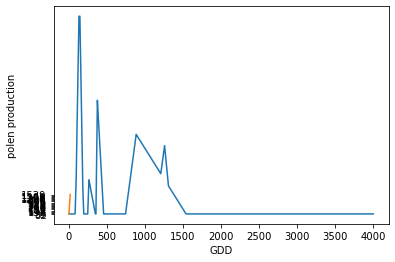

In [85]:
#Phb = Habi_outP["VAL"].tolist()
Phablist = [round(num, 1) for num in Phb]
buffer = 0.5



#print(Phablist)
almas = pd.DataFrame(columns=["GDD", "POLEN", "NECTAR", "SUGAR"])
current=0
ind= 0
vect = 0
cur_rate = 0
rate = 0
#for gdd in Habi_outP:
for idx, gdd in enumerate(Phablist):
    
    if (vect == 0) & (gdd > current):
        #print("_/")
        almas.at[ind, "POLEN"] = current
        almas.at[ind, "GDD"] = str(idx)
        vect = 1
        ind = ind + 1 
        rate = gdd-current
        current = gdd
        cur_rate = rate
        
    
    elif (vect == 2) & (gdd == current):
        #print("L_")
        almas.at[ind, "POLEN"] = current
        almas.at[ind, "GDD"] = str(idx)
        vect = 0
        ind = ind + 1 
        rate = gdd-current
        current = gdd
        cur_rate = rate
        
    elif (vect == 1) & (gdd == current):
        #print("/-")
        almas.at[ind, "POLEN"] = current
        almas.at[ind, "GDD"] = str(idx)
        vect = 0
        ind = ind + 1
        rate = gdd-current
        current = gdd
        cur_rate = rate

        
    elif (vect == 1) & (gdd > current):
        
        rate = gdd-current
        ################
        if ((rate >= cur_rate - buffer) & (rate <= cur_rate + buffer)):
            #print("/")
            current = gdd
            cur_rate = rate
        else:
            #print("/ change")
            almas.at[ind, "POLEN"] = current
            almas.at[ind, "GDD"] = str(idx)
            #almas.at[ind, "cr"] = (cur_rate)
            #almas.at[ind, "r"] = (rate)
            ind = ind + 1 
            current = gdd
            cur_rate = rate
        ################
        
    elif (vect == 1) & (gdd < current):   
        #print ("^")
        almas.at[ind, "POLEN"] = current
        almas.at[ind, "GDD"] = str(idx)
        vect = 2
        ind = ind + 1
        rate = gdd-current
        current = gdd
        cur_rate = rate
        
    elif (vect == 2) & (gdd < current):
        
        rate = gdd-current
        ################
        if ((rate >= cur_rate - buffer) & (rate <= cur_rate + buffer)):
            #print("L")
            current = gdd
            cur_rate = rate
        else:
            #print("L change")
            almas.at[ind, "POLEN"] = current
            almas.at[ind, "GDD"] = str(idx)
            #almas.at[ind, "cr"] = (cur_rate)
            #almas.at[ind, "r"] = (rate)
            ind = ind + 1 
            current = gdd
            cur_rate = rate
    
    elif (vect == 2) & (gdd > current):
        #print ("v")
        almas.at[ind, "POLEN"] = current
        almas.at[ind, "GDD"] = str(idx)
        vect = 1
        ind= ind + 1
        rate = gdd-current
        current = gdd
        cur_rate = rate
        
    elif (vect == 0) & (gdd < current):
        #print("-L")
        almas.at[ind, "POLEN"] = current
        almas.at[ind, "GDD"] = str(idx )
        vect = 2
        ind = ind + 1 
        rate = gdd-current
        current = gdd
        cur_rate = rate
        
    elif gdd == current:
        #print ("_")
        vect = 0
        rate = gdd-current
        current = gdd
        cur_rate = rate
        
print (almas)
plt.plot(Habi_outP)
plt.ylabel('polen production')
plt.xlabel('GDD')
plt.show()
        
    
        
        
        
        
    
    
    

In [6]:

%load_ext watermark

# python, ipython, packages, and machine characteristics
%watermark -v -m -p os,pandas,numpy,ipywidgets,IPython.display,ipyleaflet,math,watermark,sys,netCDF4,calendar,matplotlib

# date
print (" ")
%watermark -u -n -t -z


import os
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from ipyleaflet import Map, basemaps, Marker
import math
from pandas import DataFrame
from numpy import loadtxt
import sys
import numpy as np
import netCDF4 as nc
import calendar
import matplotlib.pyplot as plt
import watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

os             : unknown
pandas         : 1.1.3
numpy          : 1.19.2
ipywidgets     : 7.5.1
IPython.display: unknown
ipyleaflet     : 0.13.4
math           : unknown
watermark      : 2.2.0
sys            : 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
netCDF4        : 1.5.6
calendar       : unknown
matplotlib     : 3.3.2

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 142 Stepping 12, GenuineIntel
CPU cores   : 8
Architecture: 64bit

 
Last updated: Thu Aug 05 2021 12:00:01Środkowoeuropejski czas letni

